In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [2]:
save_images = False
sep = ","
enc = "utf-8"
file = "correl_vs_gnn.csv"
df = pd.read_csv(file, sep=sep, header=0, encoding=enc)

In [3]:
def plot_alg_box(df, feat="OOA", suffixes=["GNN", "Correl"], ylabel=None,
        print_latex=False, ylim=None, figsize=(12,8), yticks=None, float_format="%.2f"):
    col_names = []
    title = feat
    for i in range(len(suffixes)):
        suffix = suffixes[i]
        col_name = feat + "_" + suffix
        col_names.append(col_name)
    sub_df = df.loc[:, col_names]
    
    if print_latex:
        df_desc = sub_df.describe(include="all")
        df_desc = df_desc.loc[["mean", "std", "25%", "50%", "75%"]]
        latex_str = df_desc.to_latex(escape=False, float_format=float_format)
        latex_str = latex_str.replace("_", "\_")
        latex_str = latex_str.replace("%", "\%")
        latex_str = latex_str.replace("|S|", "$|\mathcal{S}|$")
        
        print(latex_str)
    
    sub_df.plot(kind="box", figsize=figsize, rot=90, title=title, grid=True,
        showmeans=True, ylabel=ylabel, ylim=ylim, yticks=yticks)

\begin{tabular}{lrrrr}
\toprule
{} &  OOA\_GNN &  OOA\_Correl &  OOA\_Random &  OOA\_Imperfect \\
\midrule
mean &   175.01 &        0.70 &        2.31 &           0.45 \\
std  &   104.54 &        0.06 &        1.71 &           0.10 \\
25\%  &    98.25 &        0.66 &        1.08 &           0.38 \\
50\%  &   151.50 &        0.70 &        1.97 &           0.45 \\
75\%  &   225.75 &        0.73 &        3.15 &           0.51 \\
\bottomrule
\end{tabular}



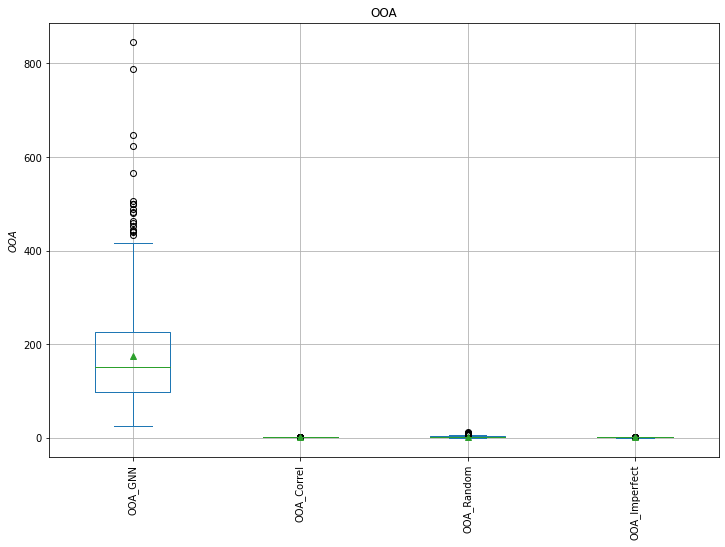

In [4]:
plot_alg_box(df=df, feat="OOA", ylabel=r"$OOA$", print_latex=True, suffixes=["GNN", "Correl", "Random", "Imperfect"])
if save_images:
    plt.savefig("correl_vs_gnn_ooa.png", bbox_inches="tight")

\begin{tabular}{lrrrr}
\toprule
{} &  $|\mathcal{S}|$\_GNN &  $|\mathcal{S}|$\_Correl &  $|\mathcal{S}|$\_Random &  $|\mathcal{S}|$\_Imperfect \\
\midrule
mean &     0.80 &        0.70 &        1.08 &           6.51 \\
std  &     0.07 &        0.05 &        1.13 &           4.40 \\
25\%  &     0.76 &        0.66 &        0.21 &           3.00 \\
50\%  &     0.80 &        0.70 &        0.80 &           6.00 \\
75\%  &     0.85 &        0.73 &        1.55 &           9.00 \\
\bottomrule
\end{tabular}



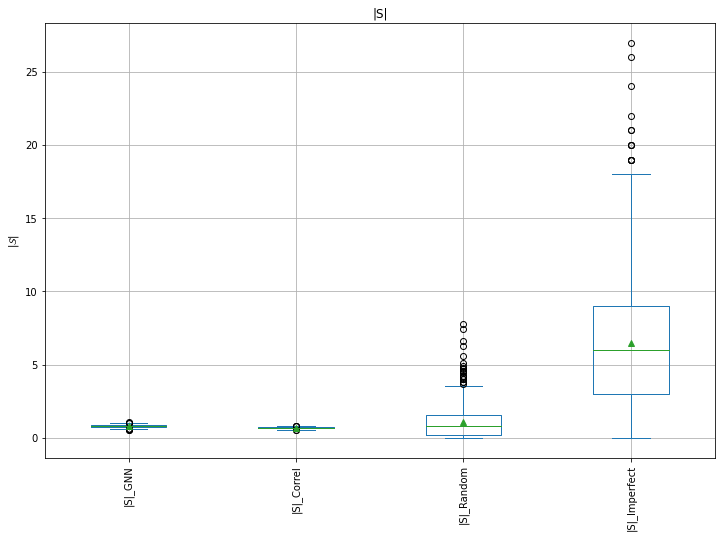

In [5]:
plot_alg_box(df=df, feat="|S|", ylabel=r"$|\mathcal{S}|$", print_latex=True, suffixes=["GNN", "Correl", "Random", "Imperfect"])
if save_images:
    plt.savefig("correl_vs_gnn_sizes.png", bbox_inches="tight")

\begin{tabular}{lrrrr}
\toprule
{} &  BCE\_GNN &  BCE\_Correl &  BCE\_Random &  BCE\_Imperfect \\
\midrule
mean &     0.00 &        0.69 &       43.51 &           2.75 \\
std  &     0.01 &        0.04 &        9.98 &           3.10 \\
25\%  &     0.00 &        0.67 &       36.47 &           1.00 \\
50\%  &     0.00 &        0.70 &       42.67 &           2.00 \\
75\%  &     0.00 &        0.72 &       49.94 &           4.00 \\
\bottomrule
\end{tabular}



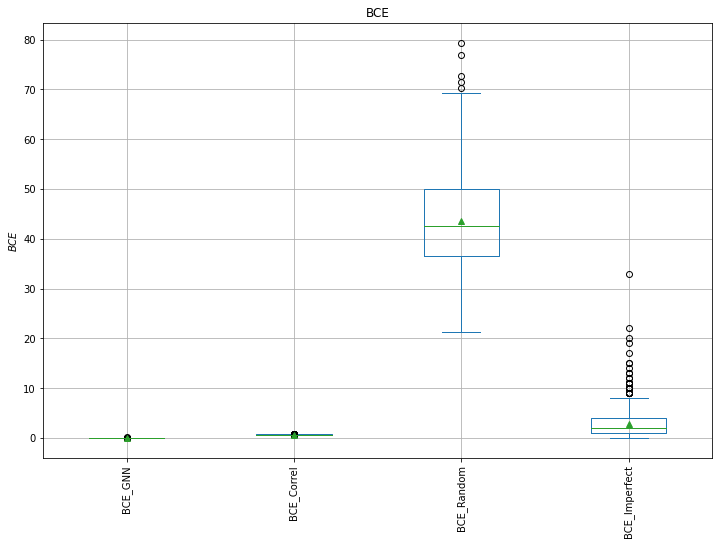

In [6]:
plot_alg_box(df=df, feat="BCE", ylabel=r"$BCE$", print_latex=True,
    suffixes=["GNN", "Correl", "Random", "Imperfect"], float_format="%.2f")
if save_images:
    plt.savefig("correl_vs_gnn_bce.png", bbox_inches="tight")

\begin{tabular}{lrrrr}
\toprule
{} &  MS\_GNN &  MS\_Correl &  MS\_Random &  MS\_Imperfect \\
\midrule
mean &  0.4246 &     0.7412 &     0.5001 &       19.9476 \\
std  &  0.0896 &     0.0880 &     0.0116 &        9.0194 \\
25\%  &  0.3587 &     0.6850 &     0.4928 &       14.0000 \\
50\%  &  0.4148 &     0.7368 &     0.5000 &       18.0000 \\
75\%  &  0.4811 &     0.7977 &     0.5073 &       25.0000 \\
\bottomrule
\end{tabular}



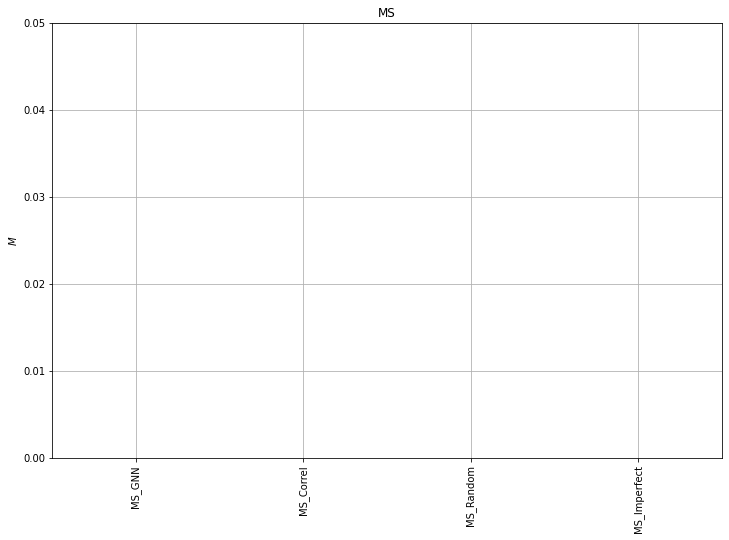

In [7]:
plot_alg_box(df=df, feat="MS", ylabel=r"$M$", print_latex=True,
    suffixes=["GNN", "Correl", "Random", "Imperfect"], float_format="%.4f",
            ylim=[0, 0.05])
if save_images:
    plt.savefig("correl_vs_gnn_bce.png", bbox_inches="tight")

In [8]:
def outliers_idxs(arr):    
    q025 = np.quantile(a=arr, q=0.25, axis=0)
    q075 = np.quantile(a=arr, q=0.75, axis=0)
    iqr = q075 - q025
    lb = q025 - 1.5 * iqr
    ub = q075 + 1.5 * iqr
    mask = (arr >= ub) | (arr <= lb)
    out_rows = np.where(mask == True)[0]
    return out_rows


def ut_test(df, alpha=0.05, feat="OOA", suffixes=["GNN", "Correl"]):
    col_names = []
    title = feat
    print(title)
    if len(suffixes) != 2:
        raise Exception("Cannot apply u- or t-Test")
    for i in range(len(suffixes)):
        suffix = suffixes[i]
        col_name = feat + "_" + suffix
        col_names.append(col_name)
    sub_df = df.loc[:, col_names]
    
    idxs_0 = outliers_idxs(arr=sub_df[col_names[0]].to_numpy())
    idxs_1 = outliers_idxs(arr=sub_df[col_names[1]].to_numpy())
    out_idxs = np.vstack((idxs_0[:, None], idxs_1[:, None]))
    out_idxs = np.unique(out_idxs)
    print("Remove {0} outliers".format(out_idxs.shape[0]))
    remaining_idxs = np.arange(df.shape[0], dtype=np.uint32)
    remaining_idxs = np.delete(remaining_idxs, out_idxs)
    sub_df = sub_df.iloc[remaining_idxs, :]
    
    is_normal = True
    for i in range(len(col_names)):
        col_name = col_names[i]
        _, p_val = st.shapiro(sub_df[col_name])
        is_col_normal = p_val < alpha
        print("{0} is normal: {1} (p={2})".format(col_name, is_col_normal, p_val))
        is_normal = is_normal and is_col_normal
    _, p_val = st.bartlett(sub_df[col_names[0]], sub_df[col_names[1]])
    equal_var = p_val < alpha
    print("Equal variance: {0} (p={1})".format(equal_var, p_val))
    if is_normal and equal_var:
        _, p_val = st.ttest_ind(a=sub_df[col_names[0]], b=sub_df[col_names[1]])
        significant = p_val < alpha
        print("T-Test for {0} is significant: {1} (p={2:.5f})".format(title, significant, p_val))
    else:
        _, p_val = st.mannwhitneyu(x=sub_df[col_names[0]], y=sub_df[col_names[1]])
        significant = p_val < alpha
        print("U-Test for {0} is significant: {1} (p={2:.5f})".format(title, significant, p_val))

In [9]:
ut_test(df=df, feat="OOA")

OOA
Remove 41 outliers
OOA_GNN is normal: True (p=1.4050971486583713e-13)
OOA_Correl is normal: False (p=0.1407829225063324)
Equal variance: True (p=0.0)
U-Test for OOA is significant: True (p=0.00000)


In [10]:
ut_test(df=df, feat="|S|")

|S|
Remove 15 outliers
|S|_GNN is normal: False (p=0.23922033607959747)
|S|_Correl is normal: False (p=0.6616366505622864)
Equal variance: True (p=1.2596017656039043e-25)
U-Test for |S| is significant: True (p=0.00000)


In [11]:
ut_test(df=df, feat="BCE")

BCE
Remove 119 outliers
BCE_GNN is normal: True (p=1.2459314589007348e-27)
BCE_Correl is normal: False (p=0.4456656873226166)
Equal variance: True (p=0.0)
U-Test for BCE is significant: True (p=0.00000)
